# CellChat

**Language:** R

**Paper:** Suoqin Jin, Christian F. Guerrero-Juarez, Lihua Zhang, Ivan Chang, Raul Ramos, Chen-Hsiang Kuan, Peggy Myung, Maksim V. Plikus, Qing Nie. Inference and analysis of cell-cell communication using CellChat.

**Code Resource:** https://github.com/sqjin/CellChat

**Claiming:** Inference of intercellular signaling networks (ligand,receptor **and their cofactors**)

**Method:** To predict signiﬁcant communications, CellChat identiﬁes differentially over-expressed ligands and receptors for each cell group. To quantify communications between two cell groups mediated by these signaling genes, CellChat associates each interaction with a probability value.

**Database:** CellChatDB incorporates signaling molecule interaction information from the KEGG Pathway database and recent experimental studies. It contains 2,021 validated molecular  interactions, including 60% of paracrine/autocrine signaling interactions, 21% of extracellular matrix (ECM)-receptor interactions and 19% of cell–cell contact interactions.


## Input

1. scRNA-seq data: gene-expression matrix (normalized) with rows as genes and columns as cells

2. cell type annotation

Here, we use the example data from https://github.com/sqjin/CellChat/blob/master/tutorial/CellChat-vignette.html

Download link: https://ndownloader.figshare.com/files/25950872


## Example
### Installation

Install UMAP python pacakge for dimension reduction: 

`` pip install umap-learn``

In [ ]:
install.packages('NMF')
devtools::install_github("jokergoo/circlize")
devtools::install_github("jokergoo/ComplexHeatmap")
devtools::install_github("sqjin/CellChat")

In [1]:
library(CellChat)
library(patchwork)
options(stringsAsFactors = FALSE)

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2



### Part I: Data input & processing and initialization of CellChat object
#### Load Data

In [2]:
load(url("https://ndownloader.figshare.com/files/25950872")) # This is a combined data from two biological conditions: normal and diseases
data.input <- data_humanSkin$data # normalized data matrix
meta <- data_humanSkin$meta # a dataframe with rownames containing cell mata data
cell.use <- rownames(meta)[meta$condition == "LS"] # extract the cell names from disease data
# Prepare input data for CellChat analysis
data.input <- data.input[, cell.use]
meta <- meta[cell.use, ]

In [4]:
str(data.input)
head(meta)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:4119559] 0 1 6 13 15 16 17 22 24 30 ...
  ..@ p       : int [1:5012] 0 4064 7504 10940 13718 16363 19325 22489 25141 27734 ...
  ..@ Dim     : int [1:2] 17328 5011
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:17328] "A1BG" "A1BG-AS1" "A2M" "A2M-AS1" ...
  .. ..$ : chr [1:5011] "S1_AACTCCCAGAGCTGCA" "S1_CAACCAATCCTCATTA" "S1_CGCTATCTCCTAGTGA" "S1_ATTTCTGCAGGACGTA" ...
  ..@ x       : num [1:4119559] 0.577 0.577 0.941 1.207 0.941 ...
  ..@ factors : list()


,patient.id,condition,labels
,<chr>,<chr>,<fct>
S1_AACTCCCAGAGCTGCA,Patient1,LS,Inflam. FIB
S1_CAACCAATCCTCATTA,Patient1,LS,FBN1+ FIB
S1_CGCTATCTCCTAGTGA,Patient1,LS,Inflam. FIB
S1_ATTTCTGCAGGACGTA,Patient1,LS,Inflam. FIB
S1_TGAGCCGAGCTGGAAC,Patient1,LS,Inflam. FIB
S1_CAGGTGCAGCCCAACC,Patient1,LS,Inflam. FIB


#### Create a CellChat object

In [5]:
cellchat <- createCellChat(object = data.input, meta = meta, group.by = "labels")

Create a CellChat object from a data matrix

Set cell identities for the new CellChat object



The cell groups used for CellChat analysis are  APOE+ FIB FBN1+ FIB COL11A1+ FIB Inflam. FIB cDC1 cDC2 LC Inflam. DC TC Inflam. TC CD40LG+ TC NKT 


#### Set the ligand-receptor interaction database

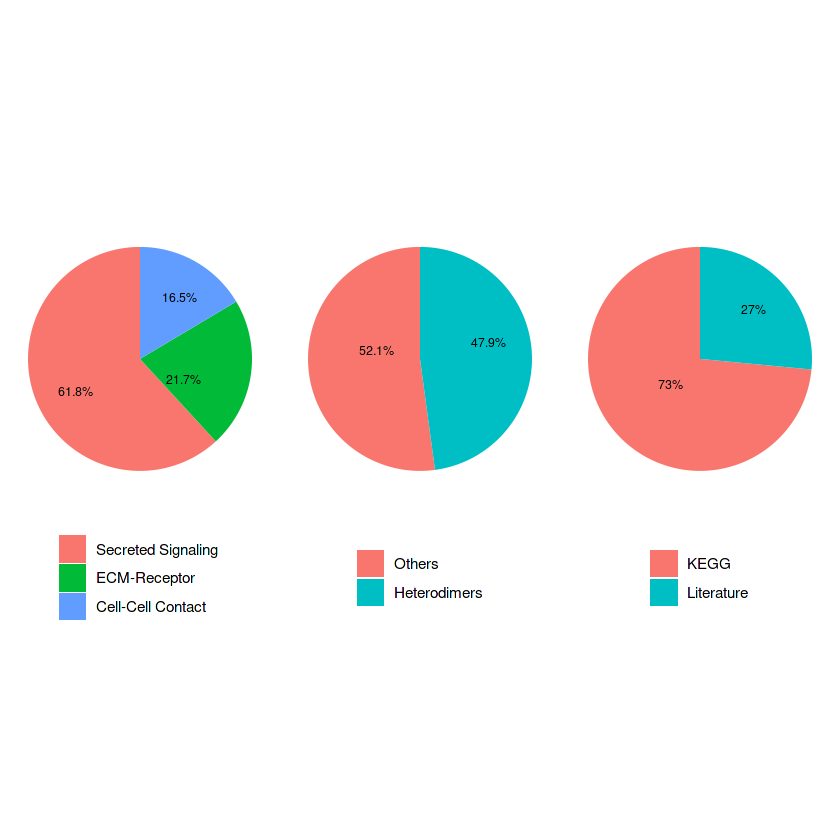

In [6]:
CellChatDB <- CellChatDB.human # use CellChatDB.mouse if running on mouse data
showDatabaseCategory(CellChatDB)

In [7]:
# Show the structure of the database
dplyr::glimpse(CellChatDB$interaction)

Rows: 1,939
Columns: 11
$ interaction_name   <chr> "TGFB1_TGFBR1_TGFBR2", "TGFB2_TGFBR1_TGFBR2", "TGFB…
$ pathway_name       <chr> "TGFb", "TGFb", "TGFb", "TGFb", "TGFb", "TGFb", "TG…
$ ligand             <chr> "TGFB1", "TGFB2", "TGFB3", "TGFB1", "TGFB1", "TGFB2…
$ receptor           <chr> "TGFbR1_R2", "TGFbR1_R2", "TGFbR1_R2", "ACVR1B_TGFb…
$ agonist            <chr> "TGFb agonist", "TGFb agonist", "TGFb agonist", "TG…
$ antagonist         <chr> "TGFb antagonist", "TGFb antagonist", "TGFb antagon…
$ co_A_receptor      <chr> "", "", "", "", "", "", "", "", "", "", "", "", "",…
$ co_I_receptor      <chr> "TGFb inhibition receptor", "TGFb inhibition recept…
$ evidence           <chr> "KEGG: hsa04350", "KEGG: hsa04350", "KEGG: hsa04350…
$ annotation         <chr> "Secreted Signaling", "Secreted Signaling", "Secret…
$ interaction_name_2 <chr> "TGFB1 - (TGFBR1+TGFBR2)", "TGFB2 - (TGFBR1+TGFBR2)…


In [8]:
# use a subset of CellChatDB for cell-cell communication analysis
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling") # use Secreted Signaling
# use all CellChatDB for cell-cell communication analysis
# CellChatDB.use <- CellChatDB # simply use the default CellChatDB
# set the used database in the object
cellchat@DB <- CellChatDB.use

#### Preprocessing the expression data for cell-cell communication analysis
To infer the cell state-specific communications, CellChat identifies over-expressed ligands or receptors in one cell group and then identifies over-expressed ligand-receptor interactions if either ligand or receptor is over-expressed.

It also provides a function to project gene expression data onto protein-protein interaction (PPI) network. Specifically, a diffusion process is used to smooth genes’ expression values based on their neighbors’ defined in a high-confidence experimentally validated protein-protein network.

In [9]:
# subset the expression data of signaling genes for saving computation cost
cellchat <- subsetData(cellchat) # This step is necessary even if using the whole database
future::plan("multiprocess", workers = 4) # do parallel
cellchat <- identifyOverExpressedGenes(cellchat)
cellchat <- identifyOverExpressedInteractions(cellchat)

Warning message:
“Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'.”


### Part II: Inference of cell-cell communication network
CellChat infers the biologically significant cell-cell communication by assigning each interaction with a probability value and peforming a permutation test. CellChat models the probability of cell-cell communication by integrating gene expression with prior known knowledge of the interactions between signaling ligands, receptors and their cofactors using the law of mass action.

#### Compute the communication probability and infer cellular communication network

In [10]:
cellchat <- computeCommunProb(cellchat)
# Filter out the cell-cell communication if there are only few number of cells in certain cell groups
cellchat <- filterCommunication(cellchat, min.cells = 10)

#### Extract the inferred cellular communication network as a data frame

In [13]:
df.net <- subsetCommunication(cellchat) # returns a data frame consisting of all the inferred cell-cell communications at the level of ligands/receptors 
head(df.net)
df.net <- subsetCommunication(cellchat, slot.name = "netP") # to access the the inferred communications at the level of signaling pathways
head(df.net)
df.net <- subsetCommunication(cellchat, sources.use = c(1,2), targets.use = c(4,5)) # gives the inferred cell-cell communications sending from cell groups 1 and 2 to cell groups 4 and 5
head(df.net)
df.net <- subsetCommunication(cellchat, signaling = c("FGF", "MIF")) # gives the inferred cell-cell communications mediated by signaling WNT and TGFb
head(df.net)

,source,target,ligand,receptor,prob,pval,interaction_name,interaction_name_2,pathway_name,annotation,evidence
,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>
1,APOE+ FIB,APOE+ FIB,FGF7,FGFR1,0.006276293,0,FGF7_FGFR1,FGF7 - FGFR1,FGF,Secreted Signaling,PMC: 4393358
2,FBN1+ FIB,APOE+ FIB,FGF7,FGFR1,0.004854738,0,FGF7_FGFR1,FGF7 - FGFR1,FGF,Secreted Signaling,PMC: 4393358
3,COL11A1+ FIB,APOE+ FIB,FGF7,FGFR1,0.003575889,0,FGF7_FGFR1,FGF7 - FGFR1,FGF,Secreted Signaling,PMC: 4393358
4,APOE+ FIB,FBN1+ FIB,FGF7,FGFR1,0.009362611,0,FGF7_FGFR1,FGF7 - FGFR1,FGF,Secreted Signaling,PMC: 4393358
5,FBN1+ FIB,FBN1+ FIB,FGF7,FGFR1,0.007247115,0,FGF7_FGFR1,FGF7 - FGFR1,FGF,Secreted Signaling,PMC: 4393358
6,COL11A1+ FIB,FBN1+ FIB,FGF7,FGFR1,0.005341442,0,FGF7_FGFR1,FGF7 - FGFR1,FGF,Secreted Signaling,PMC: 4393358


,source,target,pathway_name,prob,pval
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,APOE+ FIB,APOE+ FIB,FGF,0.006276293,0
2,APOE+ FIB,CD40LG+ TC,CXCL,0.049417517,0
3,APOE+ FIB,CD40LG+ TC,MIF,0.030976467,0
4,APOE+ FIB,cDC1,MIF,0.131062591,0
5,APOE+ FIB,cDC2,COMPLEMENT,0.074577507,0
6,APOE+ FIB,cDC2,CXCL,0.021125357,0


,source,target,ligand,receptor,prob,pval,interaction_name,interaction_name_2,pathway_name,annotation,evidence
,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>
1,APOE+ FIB,Inflam. FIB,FGF7,FGFR1,0.008251458,0,FGF7_FGFR1,FGF7 - FGFR1,FGF,Secreted Signaling,PMC: 4393358
2,FBN1+ FIB,Inflam. FIB,FGF7,FGFR1,0.006385410,0,FGF7_FGFR1,FGF7 - FGFR1,FGF,Secreted Signaling,PMC: 4393358
3,APOE+ FIB,cDC1,MIF,CD74_CD44,0.131062591,0,MIF_CD74_CD44,MIF - (CD74+CD44),MIF,Secreted Signaling,PMID: 29637711; PMID: 26175090
4,FBN1+ FIB,cDC1,MIF,CD74_CD44,0.126808126,0,MIF_CD74_CD44,MIF - (CD74+CD44),MIF,Secreted Signaling,PMID: 29637711; PMID: 26175090


,source,target,ligand,receptor,prob,pval,interaction_name,interaction_name_2,pathway_name,annotation,evidence
,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>
1,APOE+ FIB,APOE+ FIB,FGF7,FGFR1,0.006276293,0,FGF7_FGFR1,FGF7 - FGFR1,FGF,Secreted Signaling,PMC: 4393358
2,FBN1+ FIB,APOE+ FIB,FGF7,FGFR1,0.004854738,0,FGF7_FGFR1,FGF7 - FGFR1,FGF,Secreted Signaling,PMC: 4393358
3,COL11A1+ FIB,APOE+ FIB,FGF7,FGFR1,0.003575889,0,FGF7_FGFR1,FGF7 - FGFR1,FGF,Secreted Signaling,PMC: 4393358
4,APOE+ FIB,FBN1+ FIB,FGF7,FGFR1,0.009362611,0,FGF7_FGFR1,FGF7 - FGFR1,FGF,Secreted Signaling,PMC: 4393358
5,FBN1+ FIB,FBN1+ FIB,FGF7,FGFR1,0.007247115,0,FGF7_FGFR1,FGF7 - FGFR1,FGF,Secreted Signaling,PMC: 4393358
6,COL11A1+ FIB,FBN1+ FIB,FGF7,FGFR1,0.005341442,0,FGF7_FGFR1,FGF7 - FGFR1,FGF,Secreted Signaling,PMC: 4393358


#### Infer the cell-cell communication at a signaling pathway level
CellChat computes the communication probability on signaling pathway level by summarizing the communication probabilities of all ligands-receptors interactions associated with each signaling pathway.

NB: The inferred intercellular communication network of each ligand-receptor pair and each signaling pathway is stored in the slot ‘net’ and ‘netP’, respectively.

In [17]:
cellchat <- computeCommunProbPathway(cellchat)
str(cellchat@net)
str(cellchat@netP)

List of 2
 $ prob: num [1:12, 1:12, 1:656] 0 0 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "dimnames")=List of 3
  .. ..$ : chr [1:12] "APOE+ FIB" "FBN1+ FIB" "COL11A1+ FIB" "Inflam. FIB" ...
  .. ..$ : chr [1:12] "APOE+ FIB" "FBN1+ FIB" "COL11A1+ FIB" "Inflam. FIB" ...
  .. ..$ : chr [1:656] "TGFB1_TGFBR1_TGFBR2" "TGFB2_TGFBR1_TGFBR2" "TGFB3_TGFBR1_TGFBR2" "TGFB1_ACVR1B_TGFBR2" ...
 $ pval: num [1:12, 1:12, 1:656] 1 1 1 1 1 1 1 1 1 1 ...
  ..- attr(*, "dimnames")=List of 3
  .. ..$ : chr [1:12] "APOE+ FIB" "FBN1+ FIB" "COL11A1+ FIB" "Inflam. FIB" ...
  .. ..$ : chr [1:12] "APOE+ FIB" "FBN1+ FIB" "COL11A1+ FIB" "Inflam. FIB" ...
  .. ..$ : chr [1:656] "TGFB1_TGFBR1_TGFBR2" "TGFB2_TGFBR1_TGFBR2" "TGFB3_TGFBR1_TGFBR2" "TGFB1_ACVR1B_TGFBR2" ...
List of 2
 $ pathways: chr [1:13] "MIF" "GALECTIN" "CXCL" "COMPLEMENT" ...
 $ prob    : num [1:12, 1:12, 1:13] 0 0 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "dimnames")=List of 3
  .. ..$ : chr [1:12] "APOE+ FIB" "FBN1+ FIB" "COL11A1+ FIB" "Inflam. FIB" ...
  .. ..$

#### Calculate the aggregated cell-cell communication network
It can calculate the aggregated cell-cell communication network by counting the number of links or summarizing the communication probability. 

In [18]:
cellchat <- aggregateNet(cellchat)

It can also visualize the aggregated cell-cell communication network. For example, showing the number of interactions or the total interaction strength (weights) between any two cell groups using circle plot.

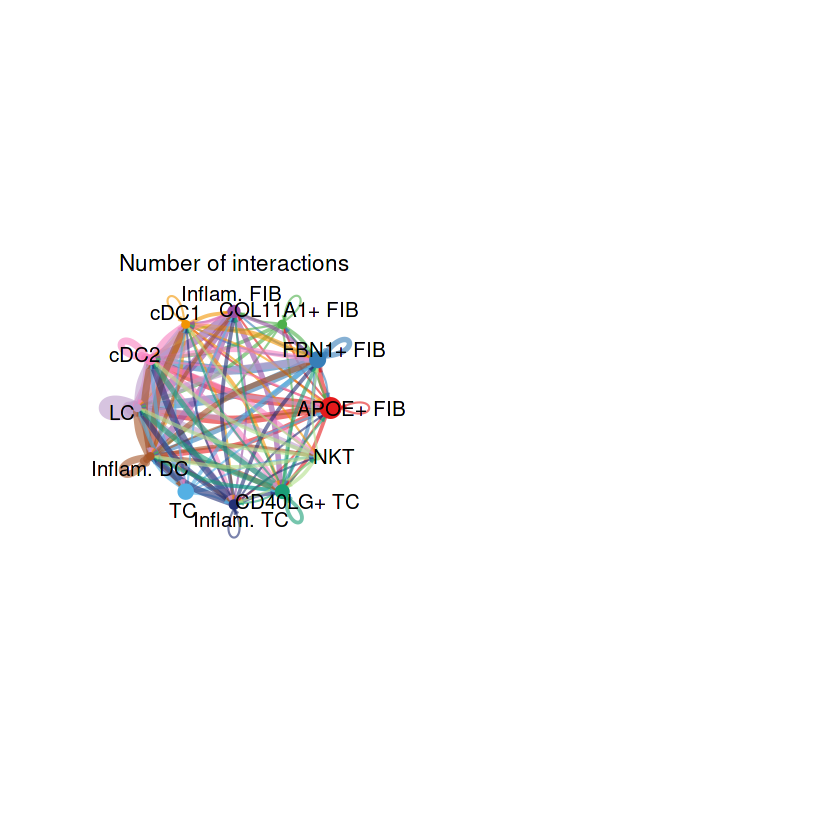

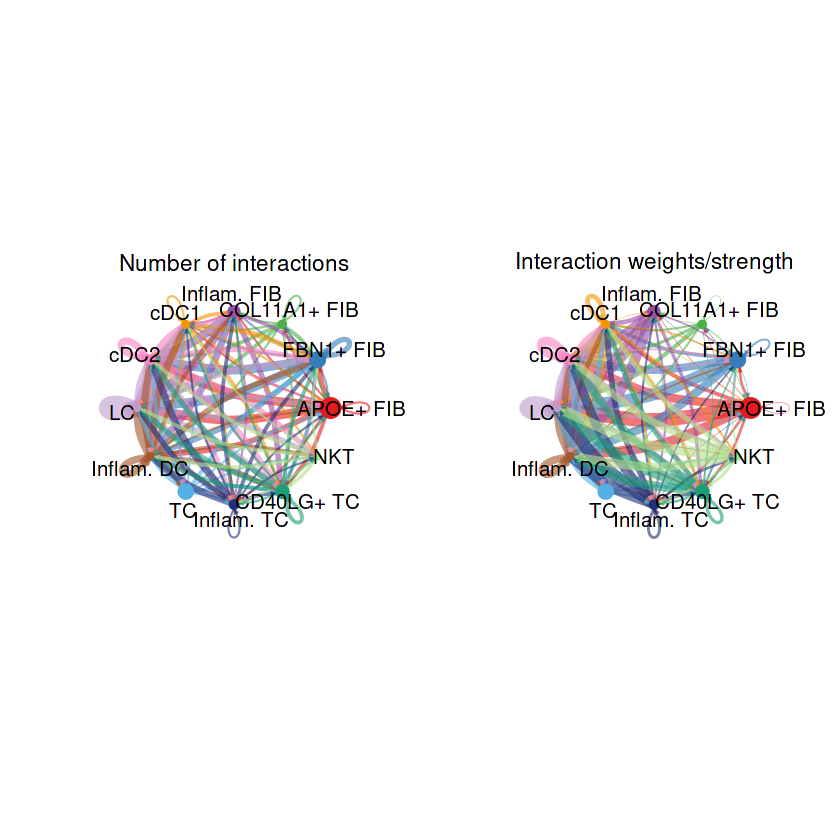

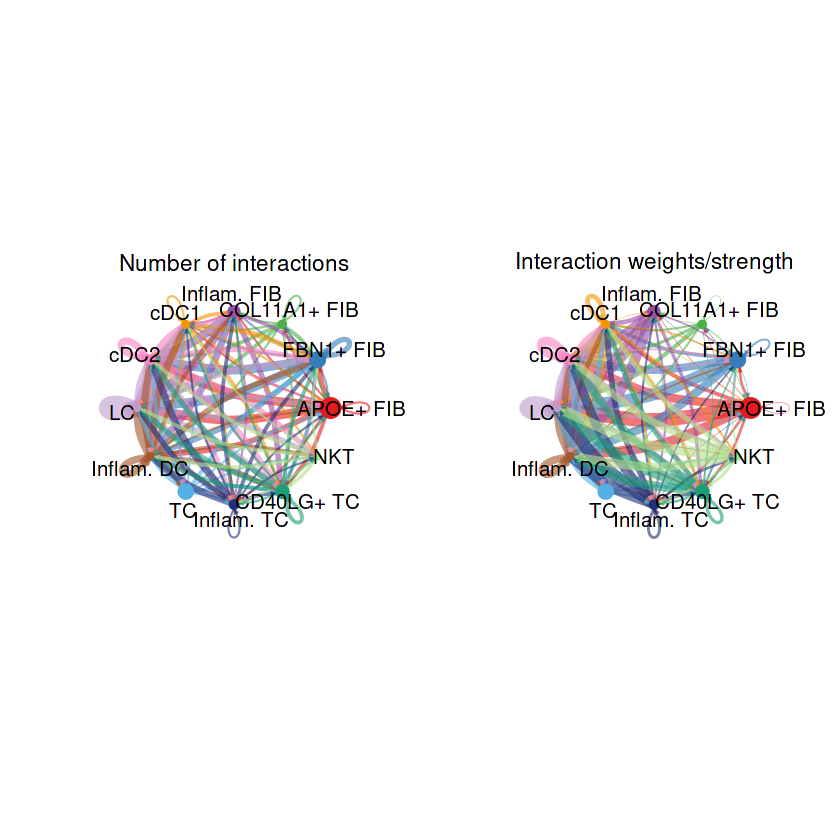

In [21]:
groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellchat@net$count, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Number of interactions")
netVisual_circle(cellchat@net$weight, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")

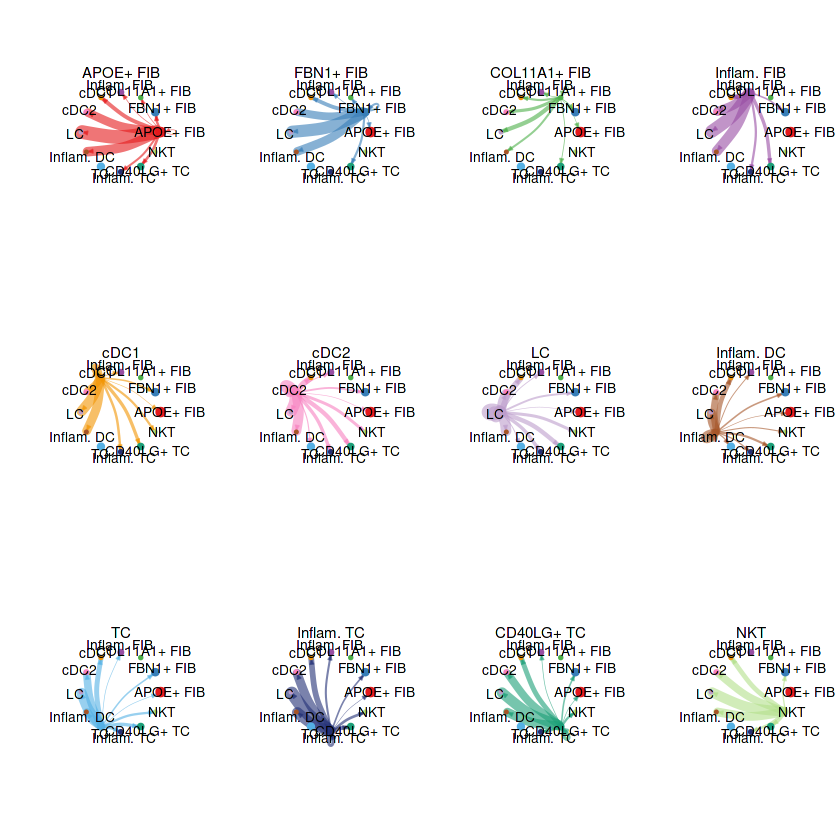

In [22]:
# we can examine the signaling sent from each cell group
mat <- cellchat@net$weight
par(mfrow = c(3,4), xpd=TRUE)
for (i in 1:nrow(mat)) {
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, edge.weight.max = max(mat), title.name = rownames(mat)[i])
}

### Part III: Visualization of cell-cell communication network

Upon infering the cell-cell communication network, CellChat provides various functionality for further data exploration, analysis, and visualization.

    It provides several ways for visualizing cell-cell communication network, including hierarchical plot, circle plot, Chord diagram, and bubble plot.

    It provides an easy-to-use tool for extracting and visualizing high-order information of the inferred networks. For example, it allows ready prediction of major signaling inputs and outputs for cell populations and how these populations and signals coordinate together for functions.

    It can quantitatively characterize and compare the inferred cell-cell communication networks using an integrated approach by combining social network analysis, pattern recognition, and manifold learning approaches.
    
    
For more information, check out https://github.com/sqjin/CellChat/blob/master/tutorial/CellChat-vignette.html


Edit by: Xie Zihong
Last Updated: October 11, 2021